In [1]:
from ML_fit_enu.src.ML_fit_neutrinos.multiple_obs_fit.read_LHEF import read_LHEF_data
import numpy as np
import torch
import matplotlib.pyplot as plt
from data_errors import compute_errors
from MC_data_reps import generate_MC_replicas

In [2]:
num_obs = 1
data, data_min,data_max ,xvals_per_obs, binwidths,xlabels, events_per_obs =read_LHEF_data(0,num_obs)
REPLICAS = 5
fit_level = 2
l1 = 15
l2 = 30
l3 = 15
lr = 0.001

In [3]:

Enu = np.array(xvals_per_obs)
x_nu = (Enu - Enu.min()) / (Enu.max() - Enu.min())
x_nu = torch.tensor(x_nu, dtype=torch.float32).view(-1, 1)


sig_sys,sig_tot, cov_matrix = compute_errors(data,data_min,data_max,num_obs)  
level0,level1,level2 = generate_MC_replicas(REPLICAS,num_obs,data,sig_sys)
level1_means,level1_stds,level2_means,level2_stds,level0_means,level0_stds = [],[],[],[],[],[],

for i in range(REPLICAS):

    level0_mean, level0_std = level0[i].mean(), level0[i].std()
    level0[i] = (level0[i] - level0_mean) / level0_std    
    level0[i] = torch.tensor(level0[i], dtype=torch.float32).view(-1, 1)

    level1_mean, level1_std = level1[i].mean(), level1[i].std()
    level1[i] = (level1[i] - level1_mean) / level1_std    
    level1[i] = torch.tensor(level1[i], dtype=torch.float32).view(-1, 1)

    level2_mean, level2_std = level2[i].mean(), level2[i].std()
    level2[i] = (level2[i] - level2_mean) / level2_std    
    level2[i] = torch.tensor(level2[i], dtype=torch.float32).view(-1, 1)

    level1_means.append(level1_mean)
    level1_stds.append(level1_std)
    level0_means.append(level0_mean)
    level0_stds.append(level0_std)
    level2_means.append(level2_mean)
    level2_stds.append(level2_std)
    

/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_29831/2382604719.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  level0[i] = torch.tensor(level0[i], dtype=torch.float32).view(-1, 1)
/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_29831/2382604719.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  level1[i] = torch.tensor(level1[i], dtype=torch.float32).view(-1, 1)
/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_29831/2382604719.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  level2[i] = torch.t

In [4]:
if fit_level ==0:
    pred = level0
    pred_means = level0_means
    pred_stds = level0_stds
if fit_level ==1:
    pred = level1
    pred_means = level1_means
    pred_stds = level1_stds
if fit_level ==2:
    pred = level2
    pred_means = level2_means
    pred_stds = level2_stds

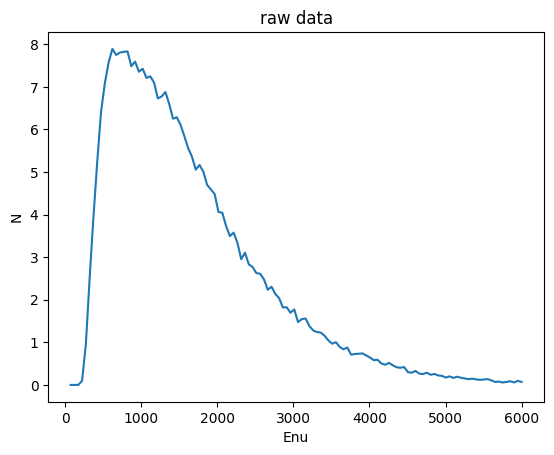

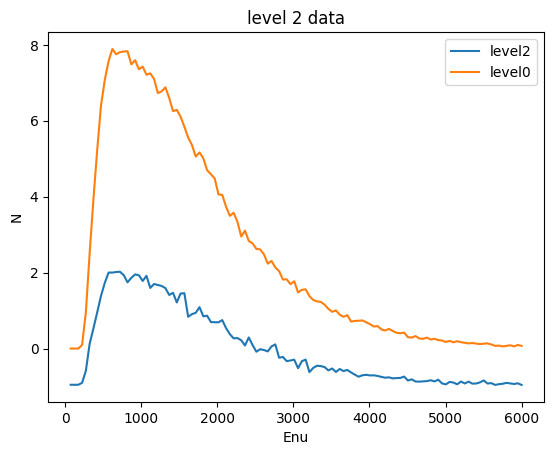

In [5]:
for i in range(num_obs):
    plt.plot(xvals_per_obs[i],events_per_obs[i])
    plt.xlabel(xlabels[i])
    plt.ylabel('N')
    plt.title("raw data")
    plt.show()

start = 0
for i in range(num_obs):
    plt.plot(
        xvals_per_obs[i], level2[0][start : len(events_per_obs[i]) + start], label="level2"
    )
    plt.plot(xvals_per_obs[i], events_per_obs[i],label="level0")
    plt.xlabel(xlabels[i])
    plt.legend()
    plt.ylabel("N")
    plt.title("level 2 data")
    plt.show()
    start += len(events_per_obs[i])

In [6]:
#specify MLP
class SimplePerceptron(torch.nn.Module):
    def __init__(self, l1,l2,l3):
        super(SimplePerceptron, self).__init__()
        self.linear = torch.nn.Linear(1,l1)
        self.hidden = torch.nn.Linear(l1,l2)
        self.hidden2 = torch.nn.Linear(l2,l3)
        self.hidden3 = torch.nn.Linear(l3,1)
        self.relu = torch.nn.ReLU()

    def forward(self, y):
        y = self.linear(y)
        y = self.relu(y)
        y = self.hidden(y)
        y = self.relu(y)
        y = self.hidden2(y)
        y = self.relu(y)
        y = self.hidden3(y)

        return y

In [7]:
import torch.nn as nn
class CustomPreprocessing(nn.Module):
    def __init__(self, alpha,beta,gamma):
        super(CustomPreprocessing, self).__init__()
        self.alpha = nn.Parameter(torch.tensor(alpha, dtype=torch.float32, requires_grad=True))
        self.beta = nn.Parameter(torch.tensor(beta, dtype=torch.float32, requires_grad=True))
        self.gamma = nn.Parameter(torch.tensor(gamma, dtype=torch.float32, requires_grad=True))

    def forward(self, x):
        return self.gamma*(1 - x) ** self.beta * x ** (1 - self.alpha)

In [8]:
# Combine the preprocessing and MLP in a single model
class PreprocessedMLP(nn.Module):
    def __init__(self, alpha, beta, gamma,l1, l2, l3):
        super(PreprocessedMLP, self).__init__()
        self.preprocessing = CustomPreprocessing(alpha, beta,gamma)
        self.mlp = SimplePerceptron(l1, l2, l3)

    def forward(self, x):
        f_preproc = self.preprocessing(x)
        f_NN = self.mlp(x)
        f_nu = f_preproc * f_NN
        return f_nu

In [9]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss,self).__init__()

    def forward(self,pred,
    data,
    cov_matrix):
        diff = pred - data
        loss = torch.matmul(cov_matrix, diff)
        loss = (1 / pred.size(0)) * torch.dot(diff.view(-1), loss.view(-1))
        return loss

In [10]:
fits = []
for i in range(REPLICAS):
    # alpha = 0.2  
    # beta = 3   
    # gamma = 10
    alpha = 0.2  
    beta = 2   
    gamma = 2
    model = PreprocessedMLP(alpha, beta, gamma,l1, l2, l3)

    criterion = CustomLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model.train()

    nepochs = 2000

    for epoch in range(nepochs):
        optimizer.zero_grad()
        y_pred = model(x_nu) 
        loss = criterion(y_pred, pred[i],cov_matrix)

        loss.backward()
        optimizer.step()
    print(loss)

    print(f"Constrained alpha: {model.preprocessing.alpha.item()}")
    print(f"Constrained beta: {model.preprocessing.beta.item()}")
    print(f"Constrained gamma: {model.preprocessing.gamma.item()}") 
    fit = model(x_nu)
    
    fit = fit* pred_stds[i] + pred_means[i]
    fit = fit.detach().flatten().numpy()
    
    x_fit= np.linspace(0,1,1000)
    x_fit=torch.tensor(x_fit, dtype=torch.float32).view(-1, 1)

    y_pred = model(x_fit)

    x_fit = x_fit.detach().numpy()
    
    y_pred = y_pred * pred_stds[i] + pred_means[i]
    y_pred = y_pred.detach().numpy()
    fits.append(y_pred)
        

tensor(0.1241, grad_fn=<MulBackward0>)
Constrained alpha: 0.43969303369522095
Constrained beta: 0.7226952910423279
Constrained gamma: 3.001098871231079
tensor(0.1167, grad_fn=<MulBackward0>)
Constrained alpha: 0.5896012783050537
Constrained beta: 0.7176120281219482
Constrained gamma: 2.9257359504699707
tensor(0.1278, grad_fn=<MulBackward0>)
Constrained alpha: 0.7196258902549744
Constrained beta: 0.7909681797027588
Constrained gamma: 3.0584583282470703
tensor(0.1169, grad_fn=<MulBackward0>)
Constrained alpha: 0.5373510718345642
Constrained beta: 0.801357626914978
Constrained gamma: 2.9028868675231934
tensor(0.1145, grad_fn=<MulBackward0>)
Constrained alpha: 0.49745041131973267
Constrained beta: 0.7622403502464294
Constrained gamma: 2.9553568363189697


In [11]:

sigma_fit = np.std(fits,axis=0)
sigma_fit = sigma_fit.flatten()
mean_fit = np.mean(fits,axis=0)
mean_fit  = mean_fit.flatten()
sigma_data = np.sqrt(sig_tot)
x_fit  = x_fit.flatten()
x_fit = x_fit *(Enu.max()-Enu.min()) + Enu.min()

120


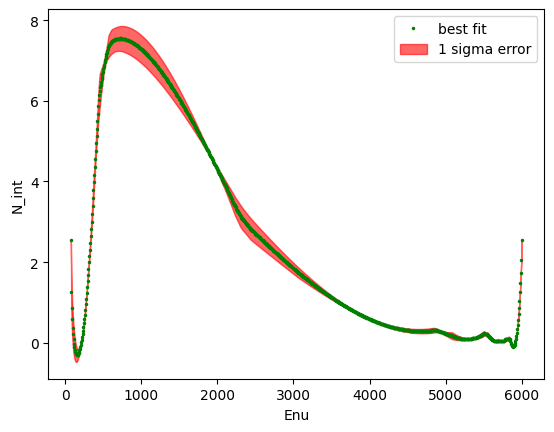

In [12]:

plt.plot(x_fit,mean_fit,'go',label='best fit',markersize=1.5)
plt.fill_between(x_fit,mean_fit+sigma_fit,mean_fit-sigma_fit,label='1 sigma error',color = 'red',alpha=0.6)
print(len(data))
# plt.errorbar(xvals_per_obs[0],data,yerr = sigma_data,label = 'mean data',fmt = '.')
# plt.plot(xvals_per_obs[0],data,'o',label = 'mean data')
plt.xlabel('Enu')
plt.ylabel('N_int')
plt.legend()    
# plt.xlim(5000,6200)
# plt.savefig('level_2_ML_fit.pdf')
plt.show()

LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001
chi square
[[0.35926189]]
 a,b,c = [1.02345569 1.01452736 1.20755629]
number of iter = 10
(50,)
my hessian
[[ 592.40411228 -684.35241556  -36.01046539]
 [-684.35241556 1776.11749074   72.44619232]
 [ -36.01046539   72.44619232    6.74741579]]
BFGS hessian
[[ 2233.1793515  -2696.89725127  -142.72584645]
 [-2696.89725127  3493.23057365   143.3829975 ]
 [ -142.72584645   143.3829975     13.40579017]]
EV BFGS
[5.63989814e+03 9.92289143e+01 6.88664482e-01] [[-0.62121382  0.75575272  0.2071985 ]
 [ 0.78282716  0.61053153  0.12013695]
 [ 0.03570739 -0.23683135  0.97089438]]
EV analytical
[2092.17920732  279.50252729    3.58728419] [[ 0.41558605 -0.90921709  0.02474908]
 [-0.90872828 -0.41621417 -0.03128377]
 [-0.03874466  0.00948909  0.99920409]]
[[0.35926189]]
LHAPDF 6.5.4[[0.35926189]]
 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_00

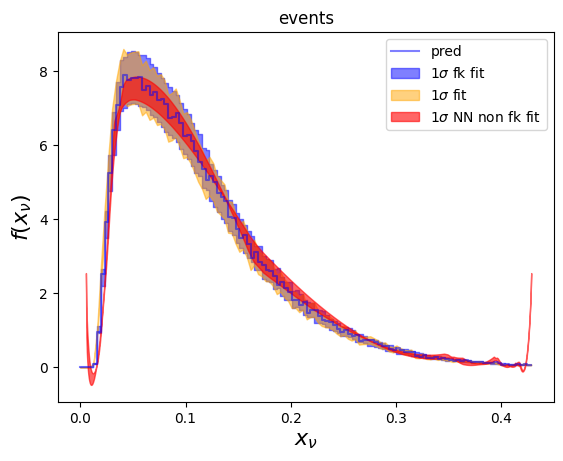

In [16]:
from ML_fit_enu.src.ML_fit_neutrinos.non_ML_fit.non_ML_fit import perform_fit
from ML_fit_enu.src.ML_fit_neutrinos.non_ML_fit.FK_non_ML_fit import perform_fit_fk
import matplotlib.pyplot as plt


(
    rawx,
    fit,
    f_err_68,
    f_err_95,
    f_err_99,
    x,
    event_fit,
    pred,
    f_err_68_cont,
    f_err_95_cont,
    f_err_99_cont,
) = perform_fit_fk()


plt.grid(axis="both")
# plt.plot(x, event_fit, drawstyle="steps-post", color="red", label="fk table fit")
plt.plot(x, pred, drawstyle="steps-post", color="blue", alpha=0.5, label="pred")
plt.xlabel(r"$x_{\nu}$", fontsize=16)
plt.ylabel(r"$f(x_{\nu})$", fontsize=16)
plt.grid(axis="both")
plt.legend()

plt.fill_between(
    x,
    (f_err_68 + event_fit),
    (-f_err_68 + event_fit),
    color="blue",
    step="post",
    alpha=0.5,
    label=r"1$\sigma$ fk fit",
)

plt.xlabel(r"$x_{\nu}$", fontsize=16)
plt.ylabel(r"$f(x_{\nu})$", fontsize=16)
plt.grid(axis="both")
plt.legend()


x, fit, f_ref, norm, f_err_68, f_err_95, f_err_99, p_min, pred = perform_fit()
plt.grid(axis="both")
# plt.plot(x, event_fit, color="red", label="fit non fk")

plt.xlabel(r"$x_{\nu}$", fontsize=16)
plt.ylabel(r"$f(x_{\nu})$", fontsize=16)
plt.grid(axis="both")
plt.legend()
plt.title("events")
plt.fill_between(
    x,
    (f_err_68 + fit),
    (-f_err_68 + fit),
    color="orange",
    alpha=0.5,
    label=r"1$\sigma$ non ML non FK fit",
)
# plt.plot(x_fit/14000,mean_fit,'go',label='best NN non fk fit',markersize=1.5)
plt.fill_between(x_fit/14000,mean_fit+sigma_fit,mean_fit-sigma_fit,label=r"1$\sigma$ NN non fk fit",color = 'red',alpha=0.6)

plt.xlabel(r"$x_{\nu}$", fontsize=16)
plt.ylabel(r"$f(x_{\nu})$", fontsize=16)
plt.grid(axis="both")
plt.legend()

plt.show()


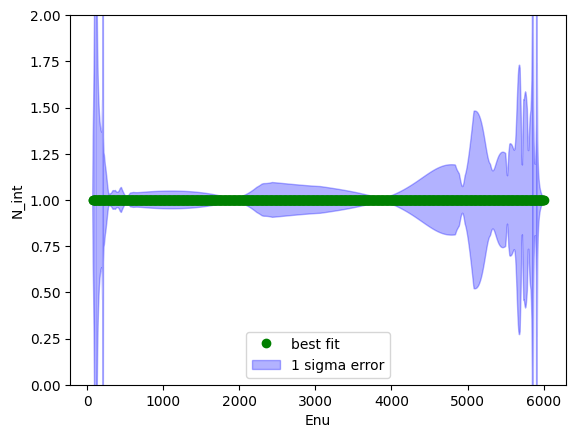

In [14]:
# This plot is to see the relative error of the ML fit
plt.plot(x_fit,mean_fit/mean_fit,'go',label='best fit')

# plt.errorbar(xvals_per_obs[0],data/data,yerr = sigma_data/data,label = 'mean data',fmt = '.')

plt.fill_between(x_fit,(mean_fit+sigma_fit)/mean_fit,(mean_fit-sigma_fit)/mean_fit,label='1 sigma error',color = 'blue',alpha=0.3)
plt.xlabel('Enu')
plt.ylabel('N_int')
plt.legend()
plt.ylim(0,2)
plt.show()